# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# copy get_dataset.py to the same directory with notebook for import 
!cp /content/drive/MyDrive/Autoencoders/get_dataset.py get_dataset.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

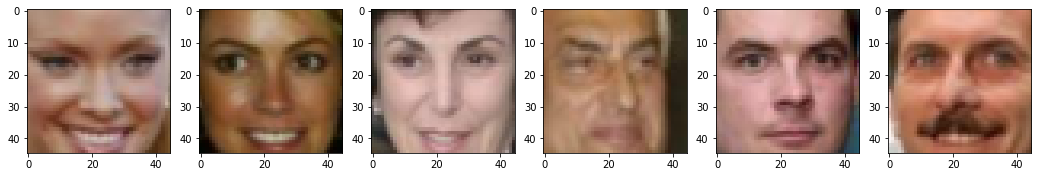

In [5]:
# print(len(data)) - we can see that there over 13,000 images

# разбиение на train и val
from sklearn.model_selection import train_test_split

X = data
X = np.float32(X)
X_train, X_val = train_test_split(X, test_size=0.3, random_state=42)

# вывод картинок на экран
plt.figure(figsize=(18,6))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(X_train[i])

# приведение к тензорам, Dataloader автоматически приводит к тензорам
from torch.utils.data import DataLoader
batch_size = 5

data_tr = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=batch_size, shuffle=True)
data_val = DataLoader(np.rollaxis(X_val, 3, 1), batch_size=batch_size, shuffle=True)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [6]:
# dim_code = <your code here> # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

# размер латентного вектора будет определен внури архитектуры сети

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      
      self.encoder_layer_1 = nn.Conv2d(3, 128, 3, padding=1)
      self.encoder_layer_2 = nn.Conv2d(128, 1, 3, padding=1)
      
      self.decoder_layer_1 = nn.Conv2d(1, 128, 3, padding=1)
      self.decoder_layer_2 = nn.Conv2d(128, 3, 3, padding=1)

      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()

    def encode(self, x):
      # <реализуйте forward проход энкодера
      x = self.encoder_layer_1(x)
      x = self.relu(x)

      x = self.encoder_layer_2(x)
      x = self.relu(x)
        
      return x
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>

        z = self.decoder_layer_1(z)
        z = self.relu(z)

        z = self.decoder_layer_2(z)
        reconstruction = self.sigmoid(z)

        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>

        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

In [8]:
criterion = nn.BCELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [9]:
rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_val), 5)

def predict_val(x, autoencoder):
  autoencoder.eval()
  with torch.no_grad():

    x = torch.from_numpy(np.rollaxis(x,3,1))   
    x = x.to(device)
    
    reconstruction, latent_code = autoencoder(x)
    x = reconstruction.cpu().detach().numpy()

    x = np.rollaxis(x,1,4)
    return x

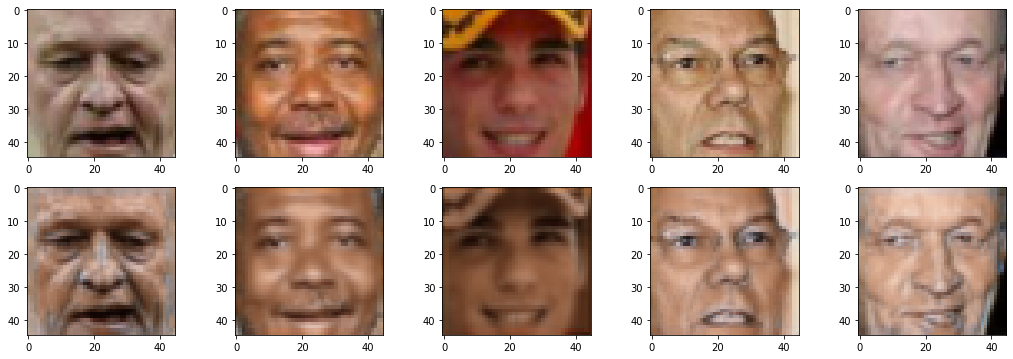

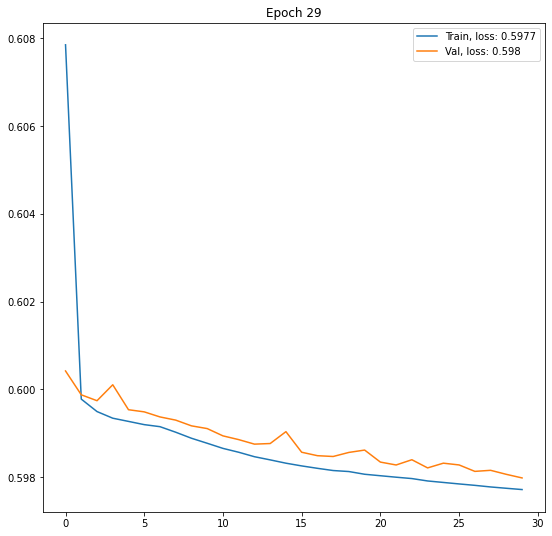

In [10]:
# <тут Ваш код тренировки автоэнкодера>

from tqdm import notebook
from IPython.display import clear_output

epochs = 30

train_losses = []
val_losses = []

for epoch in range(epochs):
  print('* Epoch %d/%d' % (epoch, epochs))

  autoencoder.train()

  avg_loss=0
  
  for i, X_batch in enumerate(notebook.tqdm(data_tr)):

    X_batch = X_batch.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    reconstruction, latent_code = autoencoder(X_batch)

    loss = criterion(reconstruction, X_batch.detach())
    avg_loss += loss / len(data_tr)

    # backward
    loss.backward() # backward-pass
    optimizer.step() # update weights

  train_loss = avg_loss
  train_losses.append(train_loss)
  print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')


  # evaluate model on validation set
  autoencoder.eval()  # testing mode
  val_loss = 0

  with torch.no_grad():
    for i, X_batch in enumerate(notebook.tqdm(data_val)):
      X_batch = X_batch.to(device)

      reconstruction, latent_code = autoencoder(X_batch)

      loss = criterion(reconstruction, X_batch.detach())
      val_loss += loss / len(data_val)

    print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
  val_losses.append(val_loss)

  x = predict_val(X_val[idx], autoencoder)
  clear_output()
  
  plt.figure(figsize=(18,6))

  for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx][i])

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(x[i])
  
  fig = plt.figure(figsize=(9, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
  plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')

  plt.title(f'Epoch {epoch}')
  plt.legend(loc='best')
    
  plt.show();

In [11]:
import os

if not os.path.isdir('checkpoint'):
  os.mkdir('checkpoint')

state = {
        'net': autoencoder.state_dict(),
         'val_loss':val_loss,
         'epoch': epoch
         }
torch.save(state, './checkpoint/ckpt_{}.pth'.format('AE'))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

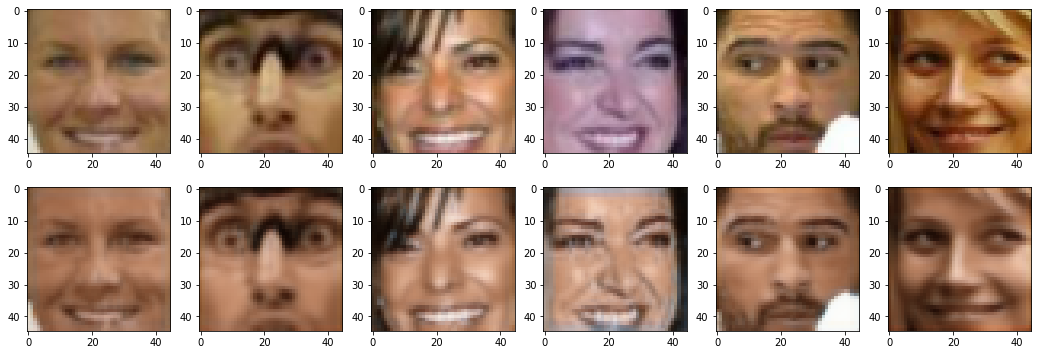

In [12]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

idx = 6

x = predict_val(X_val[:idx], autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(idx):
  plt.subplot(2, idx, i+1)
  plt.imshow(X_val[:idx][i])

  plt.subplot(2, idx, idx+i+1)
  plt.imshow(x[i])
plt.show();

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [13]:
latent_code.size()

torch.Size([3, 1, 45, 45])

(25, 45, 45, 3)


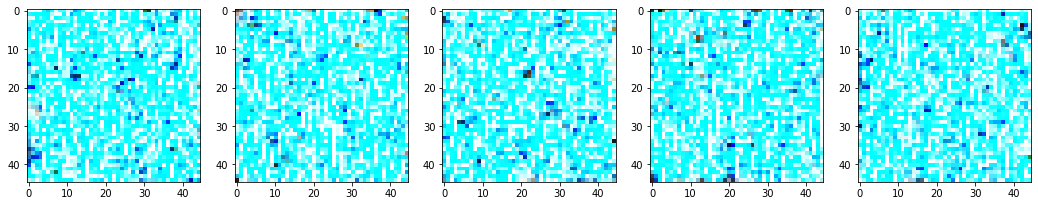

In [14]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, <latent_space_dim>)
# output = <скормите z декодеру>
# <выведите тут полученные картинки>

z = np.random.randn(25, 1, 45, 45)
z = torch.Tensor(z)
z = z.to(device)

autoencoder.eval()
with torch.no_grad():
  out = autoencoder.decode(z)
  out = out.cpu().detach().numpy()
  out = np.rollaxis(out,1,4)


print(out.shape)

plt.figure(figsize=(18,6))

for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(out[i])
plt.show();

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [15]:
# <а вот тут все это надо запрогать, да>

N = 15

indices_largest = attrs['Smiling'].astype('float32').nlargest(N).index
indices_smallest = attrs['Smiling'].astype('float32').nsmallest(N).index

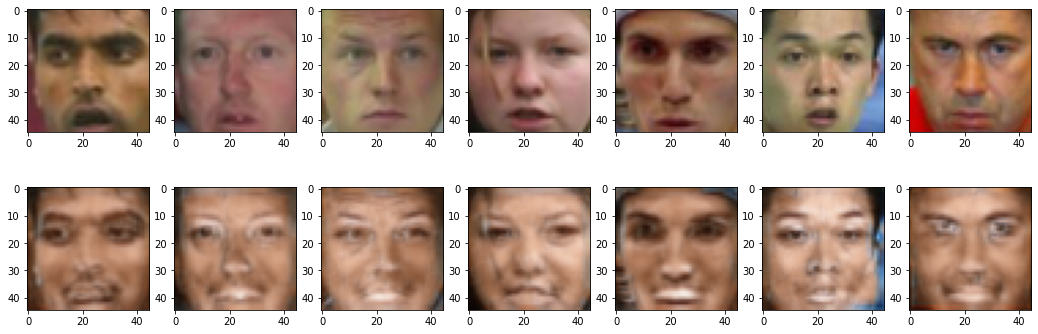

In [16]:
# латентный вектор улыбающихся людей

smiling_batch = DataLoader(np.rollaxis(X[indices_largest], 3, 1), batch_size=len(indices_largest), shuffle=False)
sad_batch = DataLoader(np.rollaxis(X[indices_smallest], 3, 1), batch_size=len(indices_largest), shuffle=False)

def get_latent_vector(my_batch):
  for batch in my_batch:
    
    batch = batch.to(device)

    autoencoder.eval()
    with torch.no_grad():
      latent_faces = autoencoder.encode(batch)
      latent_vector = latent_faces.mean(0)
  
  return latent_vector

smile_vector = get_latent_vector(smiling_batch) - get_latent_vector(sad_batch)

for batch in sad_batch:
  batch = batch.to(device)
  
  autoencoder.eval()
  with torch.no_grad():
    latent_faces_augmented = autoencoder.encode(batch) + smile_vector
    sad_faces_augmented = autoencoder.decode(latent_faces_augmented)
    
out = sad_faces_augmented.cpu().detach().numpy()
out = np.rollaxis(out,1,4)

plt.figure(figsize=(18,6))

num_img = 7
for i in range(num_img):
  plt.subplot(2, num_img, i+1)
  plt.imshow(X[indices_smallest][i])

  plt.subplot(2, num_img, num_img+i+1)
  plt.imshow(out[i])

plt.show();

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [17]:
import torchvision
from torchvision import transforms

batch_size=256

transform = transforms.Compose(
    [transforms.ToTensor()])

# , transforms.Normalize((0.1307,), (0.3081,))
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last=True)


In [18]:
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
      super().__init__()
      
      latent_dim = 25
      features = 28*28

      self.encoder_layer_1 = nn.Linear(features, features//2)

      self.encoder_layer_mu = nn.Linear(features//2, latent_dim)
      self.encoder_layer_logsigma = nn.Linear(features//2, latent_dim)

      self.decoder_layer_1 = nn.Linear(latent_dim, features//2)
      self.decoder_layer = nn.Linear(features//2, features)

      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()
  
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
          # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
          sample = torch.randn_like(mu) * torch.exp(logsigma / 2.0) + mu
          return sample
      else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>

      x = self.encoder_layer_1(x)
      x = self.relu(x)

      mu = self.encoder_layer_mu(x)
      mu = self.relu(mu)

      logsigma = self.encoder_layer_logsigma(x)
      logsigma = self.relu(logsigma)
        
      return mu, logsigma
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>

        z = self.decoder_layer_1(z)
        z = self.relu(z)

        z = self.decoder_layer(z)
        reconstruction = self.sigmoid(z)

        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [19]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # loss = <напишите код для KL-дивергенции, пользуясь формулой выше>

    loss = -0.5*torch.sum(1.0 + logsigma - torch.square(mu) - torch.exp(logsigma))

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    # loss = <binary cross-entropy>

    loss = torch.nn.BCELoss()

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):

    return (KL_divergence(mu, logsigma)/28/28/256 + log_likelihood(x, reconstruction))
    

И обучим модель:

In [20]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

def predict_val(x, autoencoder):
  autoencoder.eval()
  with torch.no_grad():
    
    N_batch = x.shape[0]
    x = x.view(x.shape[0], -1)
    x = x.to(device)
    mu, logsigma, reconstruction = autoencoder(x)
    reconstruction = reconstruction.cpu().detach()

    reconstruction = torch.reshape(reconstruction, (N_batch, 1, 28, 28))

    return reconstruction

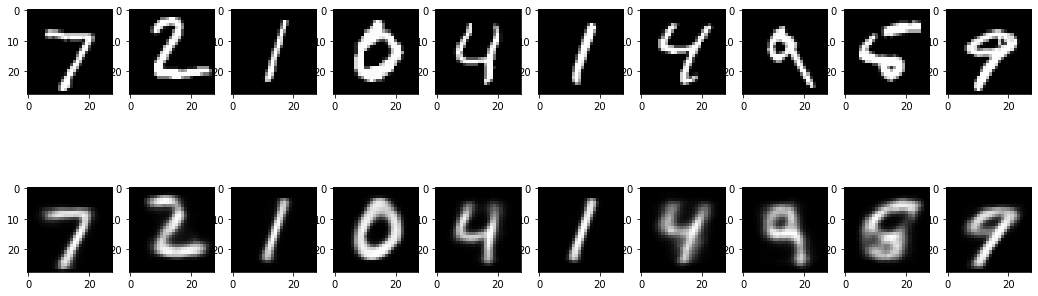

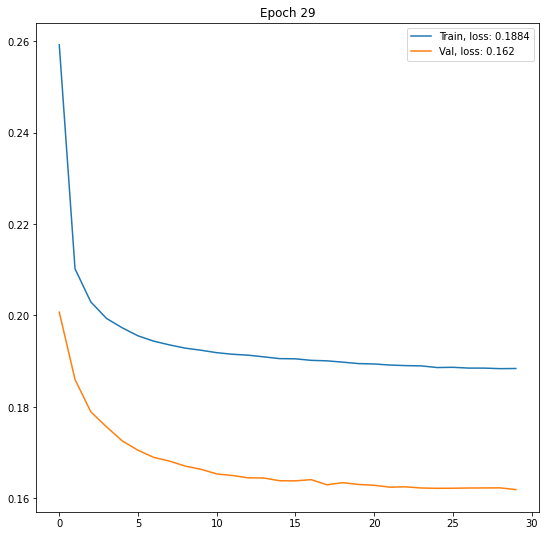

In [21]:
# <обучите модель, как и autoencoder, но на датасете MNIST>
from tqdm import notebook
from IPython.display import clear_output

epochs = 30

train_losses = []
val_losses = []

n = 10
idx = range(n)

for epoch in range(epochs):
  print('* Epoch %d/%d' % (epoch, epochs))

  autoencoder.train()

  avg_loss=0
  
  for i, batch in enumerate(notebook.tqdm(trainloader)):
    X_batch, y_batch = batch

    N_batch = X_batch.shape[0]
    X_batch = X_batch.view(X_batch.shape[0], -1)
    
    X_batch = X_batch.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    mu, logsigma, reconstruction = autoencoder(X_batch)

    loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
    avg_loss += loss / len(trainloader)

    # backward
    loss.backward() # backward-pass
    optimizer.step() # update weights

  print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
  train_loss = avg_loss
  train_losses.append(train_loss)

  # evaluate model on validation set
  autoencoder.eval()  # testing mode
  val_loss = 0

  with torch.no_grad():
    for i, batch in enumerate(notebook.tqdm(testloader)):
      X_batch, y_batch = batch
      X_batch = X_batch.view(X_batch.shape[0], -1)
      X_batch = X_batch.to(device)

      mu, logsigma, reconstruction = autoencoder(X_batch)

      loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
      val_loss += loss / len(testloader)

    print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    val_losses.append(val_loss)

  data_example = testloader.dataset.test_data[idx]
  data_example = torch.unsqueeze(data_example, 1) / 255.

  x = predict_val(data_example, autoencoder)
  clear_output()
  
  plt.figure(figsize=(18,6))

  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')

    plt.subplot(2, n, n+i+1)
    plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')

  fig = plt.figure(figsize=(9, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
  plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')

  plt.title(f'Epoch {epoch}')
  plt.legend(loc='best')
    
  plt.show();


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

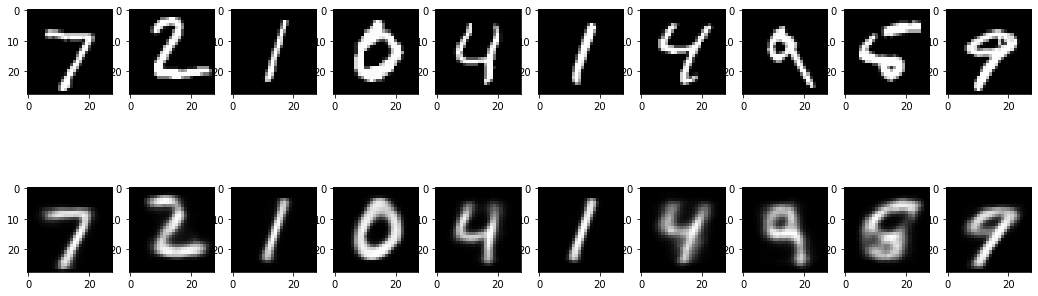

In [22]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

data_example = testloader.dataset.test_data[idx]
data_example = torch.unsqueeze(data_example, 1) / 255.

x = predict_val(data_example, autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(n):
  plt.subplot(2, n, i+1)
  plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')

  plt.subplot(2, n, n+i+1)
  plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')
plt.show();



And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

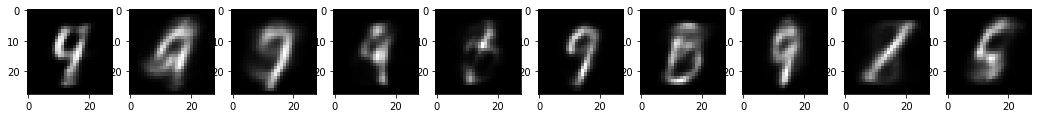

In [23]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# z = np.array([np.random.normal(0, 1, 100) for i in range(10)])

z = torch.randn((10, 1, 5, 5)).to(device)
N_batch = z.shape[0]
z = z.view(z.shape[0], -1)

# output = <скормите z декодеру>

autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decode(z)
  output = output.cpu().detach()
output = torch.reshape(output, (N_batch, 1, 28, 28))

# <выведите тут полученные картинки>

plt.figure(figsize=(18,6))

n  = 10
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.imshow(output[i].permute(1,2,0).flatten(1,-1),cmap='gray')
plt.show();

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [24]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

N = 10000

data_example = testloader.dataset.test_data[range(N)]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = testloader.dataset.targets[range(N)]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


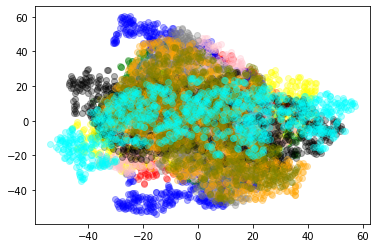

In [25]:
from sklearn.manifold import TSNE

def select_number(num, data_example):
  f = labels == num
  torch.nonzero(f)
  filtered_tensor = data_example[f]
  return filtered_tensor

nums = list(range(10))
colors = ['red', 'blue', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'cyan']

def return_latent(x):
  autoencoder.eval()
  with torch.no_grad():

    N_batch = x.shape[0]
    x = x.view(x.shape[0], -1)
    x = x.to(device)
    mu, logsigma = autoencoder.encode(x)
    mu = mu.cpu().detach().numpy()
  
  return mu 

for i in range(len(nums)):
  nums[i] = select_number(nums[i], data_example)
  nums[i] = return_latent(nums[i])
  nums[i] = TSNE(n_components=2).fit_transform(nums[i])
  plt.scatter(nums[i][:,0], nums[i][:,1], c=colors[i], alpha=0.3)
plt.show()


Что вы думаете о виде латентного представления?

Прикольно!) Мы видим как разделяется пространство по классам. При этом при попадании в некоторые области пространства легче выделить класс (например область где сконцентрированы только синие точки - соответвствует 1). В центре (0, 0) сложно выделить что-то одно так как точка может принадлежать любому классу (цифре).

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [26]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # loss = <напишите код для KL-дивергенции, пользуясь формулой выше>

    loss = -0.5*torch.sum(1.0 + logsigma - torch.square(mu) - torch.exp(logsigma))

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    # loss = <binary cross-entropy>

    loss = torch.nn.BCELoss()

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):

    return (KL_divergence(mu, logsigma)/28/28/256 + log_likelihood(x, reconstruction))
    

In [27]:
# <тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
      super().__init__()
      
      condition_dim = 10
      latent_dim = 25
      features = 28*28

      self.encoder_layer_1 = nn.Linear(features + condition_dim, (features + condition_dim)//2)

      self.encoder_layer_3_mu = nn.Linear((features + condition_dim)//2, latent_dim)
      self.encoder_layer_3_logsigma = nn.Linear((features + condition_dim)//2, latent_dim)

      self.decoder_layer_1 = nn.Linear(latent_dim + condition_dim, (features + condition_dim)//2)
      self.decoder_layer_3 = nn.Linear((features + condition_dim)//2, features)

      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()
  
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
        # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        
        sample = torch.randn_like(mu) * torch.exp(logsigma / 2.0) + mu
        
        return sample
      else:
        # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
        # на инференсе выход автоэнкодера должен быть детерминирован.
        
        return mu

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>

      x = self.encoder_layer_1(x)
      x = self.relu(x)

      mu = self.encoder_layer_3_mu(x)
      mu = self.relu(mu)

      logsigma = self.encoder_layer_3_logsigma(x)
      logsigma = self.relu(logsigma)
        
      return mu, logsigma
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>

        z = self.decoder_layer_1(z)
        z = self.relu(z)

        z = self.decoder_layer_3(z)
        reconstruction = self.sigmoid(z)

        return reconstruction

    def forward(self, x, y):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        mu, logsigma = self.encode(torch.cat((x, y), 1))

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(torch.cat((z, y), 1))

        return mu, logsigma, reconstruction

In [28]:
criterion = loss_vae

autoencoder = CVAE().to(device)

# optimizer = <Ваш любимый оптимизатор>
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [29]:
def predict_val(x, labels, autoencoder):
  autoencoder.eval()
  with torch.no_grad():
    n_classes = 10

    N_batch = x.shape[0]
    x = x.view(x.shape[0], -1)
    x = x.to(device)
    
    y = torch.zeros(N_batch, n_classes)
    y[range(y.shape[0]), labels] = 1
    y = y.to(device)
    
    
    mu, logsigma, reconstruction = autoencoder(x, y)
    
    reconstruction = reconstruction.cpu().detach()
    reconstruction = torch.reshape(reconstruction, (N_batch, 1, 28, 28))

    return reconstruction

n = 10
idx = range(n)

data_example = testloader.dataset.test_data[idx]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = testloader.dataset.targets[range(n)]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


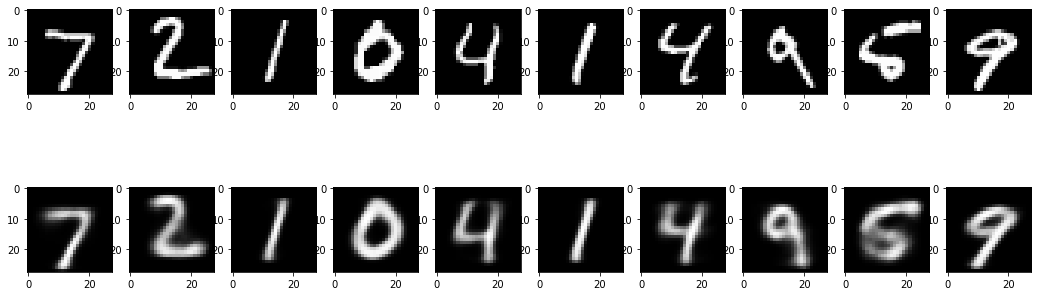

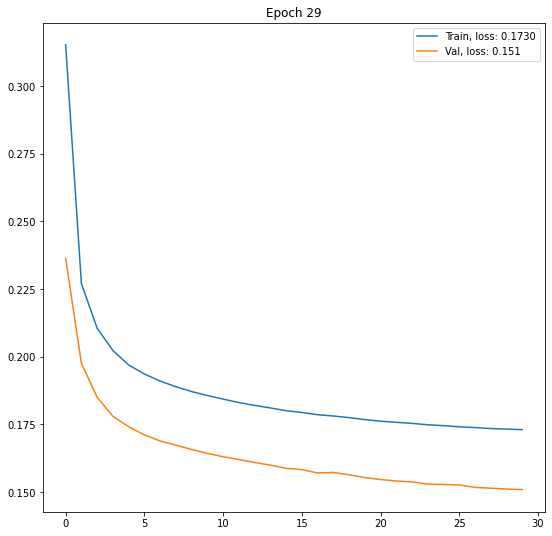

In [30]:
# <обучите модель, как и autoencoder, но на датасете MNIST>
from tqdm import notebook
from IPython.display import clear_output

epochs = 30

n_classes=10

train_losses = []
val_losses = []

for epoch in range(epochs):
  print('* Epoch %d/%d' % (epoch, epochs))

  autoencoder.train()

  avg_loss=0
  
  for i, batch in enumerate(notebook.tqdm(trainloader)):
    X_batch, y_batch = batch

    N_batch = X_batch.shape[0]
    X_batch = X_batch.view(X_batch.shape[0], -1)   
    X_batch = X_batch.to(device)

    y = torch.zeros(N_batch, n_classes)
    y[range(y.shape[0]), y_batch] = 1
    y = y.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    mu, logsigma, reconstruction = autoencoder(X_batch, y)

    loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
    avg_loss += loss / len(trainloader)

    # backward
    loss.backward() # backward-pass
    optimizer.step() # update weights

  print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
  train_loss = avg_loss
  train_losses.append(train_loss)

  # evaluate model on validation set
  autoencoder.eval()  # testing mode
  val_loss = 0

  with torch.no_grad():
    for i, batch in enumerate(notebook.tqdm(testloader)):
      X_batch, y_batch = batch
      X_batch = X_batch.view(X_batch.shape[0], -1)
      X_batch = X_batch.to(device)

      y = torch.zeros(N_batch, n_classes)
      y[range(y.shape[0]), y_batch] = 1
      y = y.to(device)

      mu, logsigma, reconstruction = autoencoder(X_batch, y)

      loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
      val_loss += loss / len(testloader)

    print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    val_losses.append(val_loss)

  x = predict_val(data_example, labels, autoencoder)
  clear_output()
  plt.figure(figsize=(18,6))

  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')

    plt.subplot(2, n, n+i+1)
    plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')

  fig = plt.figure(figsize=(9, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
  plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')

  plt.title(f'Epoch {epoch}')
  plt.legend(loc='best')
    
  plt.show();


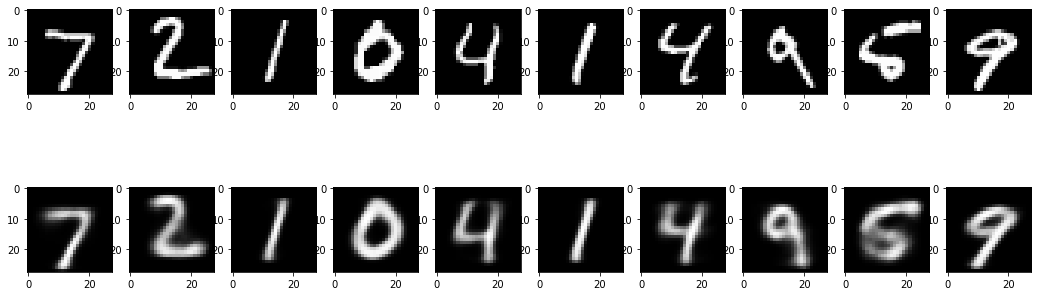

In [31]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

x = predict_val(data_example, labels, autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(n):
  plt.subplot(2, n, i+1)
  plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')

  plt.subplot(2, n, n+i+1)
  plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')
plt.show();

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

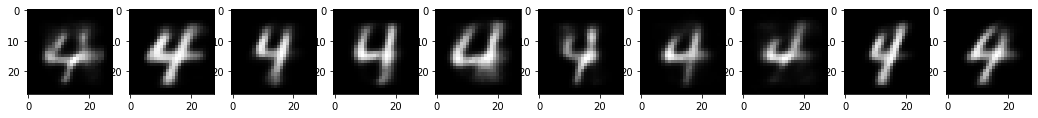

In [32]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>

# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# z = np.array([np.random.normal(0, 1, 100) for i in range(10)])

latent_dim = 25

z = torch.randn((10, 1, 5, 5)).to(device)
N_batch = z.shape[0]
z = z.view(z.shape[0], -1)

labels = [4]*N_batch

y = torch.zeros(N_batch, n_classes)
y[range(y.shape[0]), labels] = 1
y = y.to(device)



# output = <скормите z декодеру>

autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decode(torch.cat((z, y), 1))
  output = output.cpu().detach()
output = torch.reshape(output, (N_batch, 1, 28, 28))

# <выведите тут полученные картинки>

plt.figure(figsize=(18,6))

n  = 10
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.imshow(output[i].permute(1,2,0).flatten(1,-1),cmap='gray')
plt.show();

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


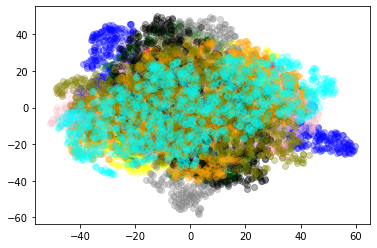

In [33]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

# распределение mu

N = 10000

data_example = testloader.dataset.test_data[range(N)]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = testloader.dataset.targets[range(N)]

from sklearn.manifold import TSNE

def select_number(num, data_example):
  f = labels == num
  torch.nonzero(f)
  filtered_tensor = data_example[f]
  return filtered_tensor

nums = list(range(10))
colors = ['red', 'blue', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'cyan']


def return_latent(x, i):
  autoencoder.eval()
  with torch.no_grad():

    N_batch = x.shape[0]
    x = x.view(x.shape[0], -1)
    x = x.to(device)

    y_batch = [i] * N_batch
    y = torch.zeros(N_batch, n_classes)
    y[range(y.shape[0]), y_batch] = 1
    y = y.to(device)

    mu, logsigma = autoencoder.encode(torch.cat((x, y), 1))

    # для распределениея mu + y
    mu = torch.cat((mu, y), 1)

    mu = mu.cpu().detach().numpy()
  
  return mu 

for i in range(len(nums)):
  nums[i] = select_number(nums[i], data_example)
  nums[i] = return_latent(nums[i], i)
  
  nums[i] = TSNE(n_components=2).fit_transform(nums[i])

  plt.scatter(nums[i][:,0], nums[i][:,1], color=colors[i], alpha=0.3)
plt.show()



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


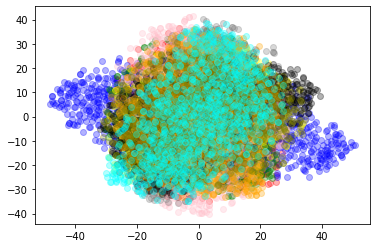

In [34]:
# нужно разбиение для латентного представления z:

# <ваш код получения латентных представлений, применения TSNE и визуализации>

# распределение mu

N = 10000

data_example = testloader.dataset.test_data[range(N)]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = testloader.dataset.targets[range(N)]

from sklearn.manifold import TSNE

def select_number(num, data_example):
  f = labels == num
  torch.nonzero(f)
  filtered_tensor = data_example[f]
  return filtered_tensor

nums = list(range(10))
colors = ['red', 'blue', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'cyan']


def return_latent(x, i):
  autoencoder.train()
  with torch.no_grad():

    N_batch = x.shape[0]
    x = x.view(x.shape[0], -1)
    x = x.to(device)

    y_batch = [i] * N_batch
    y = torch.zeros(N_batch, n_classes)
    y[range(y.shape[0]), y_batch] = 1
    y = y.to(device)

    mu, logsigma = autoencoder.encode(torch.cat((x, y), 1))

    z = autoencoder.gaussian_sampler(mu, logsigma)

    # для распределениея mu + y
    z = torch.cat((z, y), 1)
    z = z.cpu().detach().numpy()
  
  return z

for i in range(len(nums)):
  nums[i] = select_number(nums[i], data_example)
  nums[i] = return_latent(nums[i], i)
  
  nums[i] = TSNE(n_components=2, init='pca').fit_transform(nums[i])

  plt.scatter(nums[i][:,0], nums[i][:,1], color=colors[i], alpha=0.3)
plt.show()





Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

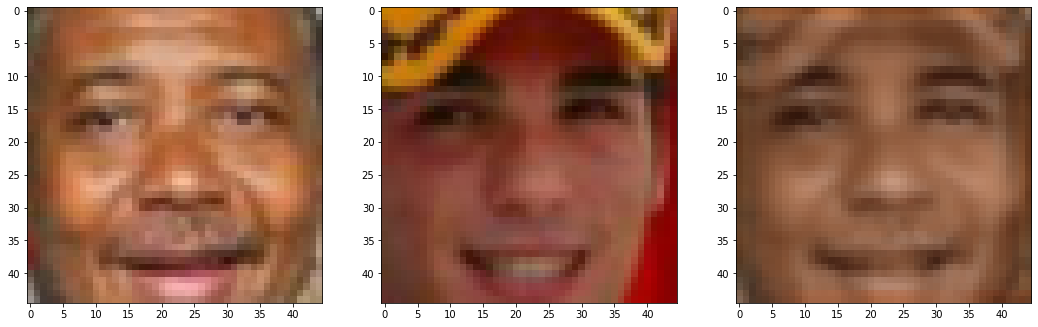

In [35]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('./checkpoint/ckpt_AE.pth')['net'])

X = X_val[[3051]]
Y = X_val[[2580]]

autoencoder.eval()
with torch.no_grad():
  X = torch.from_numpy(np.rollaxis(X,3,1))
  X = X.to(device)    
  X_latent = autoencoder.encode(X)

  Y = torch.from_numpy(np.rollaxis(Y,3,1))
  Y = Y.to(device)    
  Y_latent = autoencoder.encode(Y)

  alpha = 0.5
  XY_latent = alpha*X_latent + (1-alpha)*Y_latent

  reconstruction = autoencoder.decode(XY_latent)
  reconstruction = reconstruction.cpu().detach().numpy()
  reconstruction = np.rollaxis(reconstruction,1,4)


clear_output()
plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
plt.imshow(X_val[3051])

plt.subplot(1, 3, 2)
plt.imshow(X_val[2580])

plt.subplot(1, 3, 3)
plt.imshow(reconstruction[0])

plt.show();

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [36]:
X = data
X = np.float32(X)

noise_factor = 0.1
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [37]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

from torch.utils.data import TensorDataset

batch_size = 5

X_train_noisy, X_val_noisy, X_train, X_val = train_test_split(X_noisy, X, test_size=0.3, random_state=42)

dataset_tr = TensorDataset(torch.Tensor(np.rollaxis(X_train_noisy, 3, 1)), torch.Tensor(np.rollaxis(X_train, 3, 1)))
dataset_val = TensorDataset(torch.Tensor(np.rollaxis(X_val_noisy, 3, 1)), torch.Tensor(np.rollaxis(X_val, 3, 1)))

loader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_val), 5)

def predict_val(x, autoencoder):
  autoencoder.eval()
  with torch.no_grad():

    x = torch.from_numpy(np.rollaxis(x,3,1))
    x = x.to(torch.float32)  
    x = x.to(device)
    
    reconstruction, latent_code = autoencoder(x)
    x = reconstruction.cpu().detach().numpy()

    x = np.rollaxis(x,1,4)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


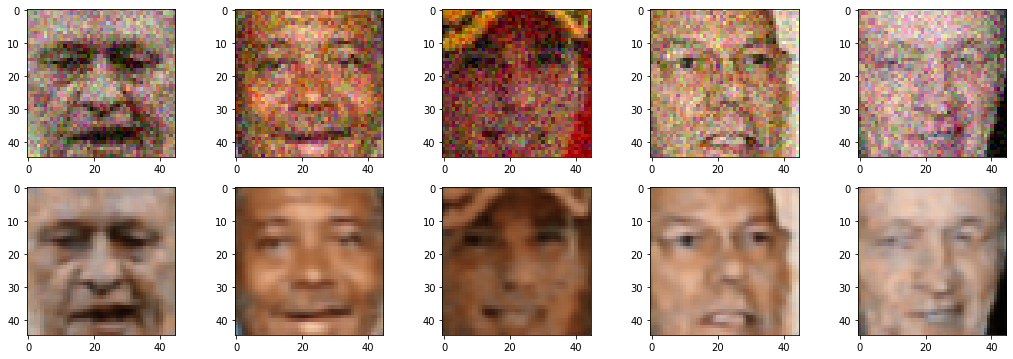

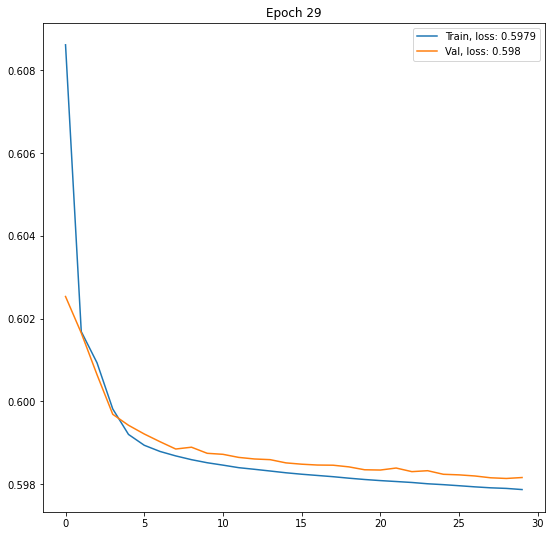

In [38]:
criterion = torch.nn.BCELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

from tqdm import notebook
from IPython.display import clear_output

epochs = 30

train_losses = []
val_losses = []

for epoch in range(epochs):
  print('* Epoch %d/%d' % (epoch, epochs))

  autoencoder.train()

  avg_loss=0
  
  for i, (X_batch_noisy, X_batch) in enumerate(notebook.tqdm(loader_tr)):
    X_batch_noisy = X_batch_noisy.to(device)
    X_batch = X_batch.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    reconstruction, latent_code = autoencoder(X_batch_noisy)

    loss = criterion(reconstruction, X_batch.detach())
    avg_loss += loss / len(data_tr)

    # backward
    loss.backward() # backward-pass
    optimizer.step() # update weights

  print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
  train_loss = avg_loss
  train_losses.append(train_loss)

  # evaluate model on validation set
  autoencoder.eval()  # testing mode
  val_loss = 0

  with torch.no_grad():
    for i, (X_batch_noisy, X_batch) in enumerate(notebook.tqdm(loader_val)):
      X_batch_noisy = X_batch_noisy.to(device)
      X_batch = X_batch.to(device)

      reconstruction, latent_code = autoencoder(X_batch_noisy)

      loss = criterion(reconstruction, X_batch.detach())
      val_loss += loss / len(data_val)

    print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    val_losses.append(val_loss)

  x = predict_val(X_val_noisy[idx], autoencoder)
  clear_output()
  plt.figure(figsize=(18,6))

  for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val_noisy[idx][i])

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(x[i])

  fig = plt.figure(figsize=(9, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
  plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')

  plt.title(f'Epoch {epoch}')
  plt.legend(loc='best')
  
  plt.show();



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


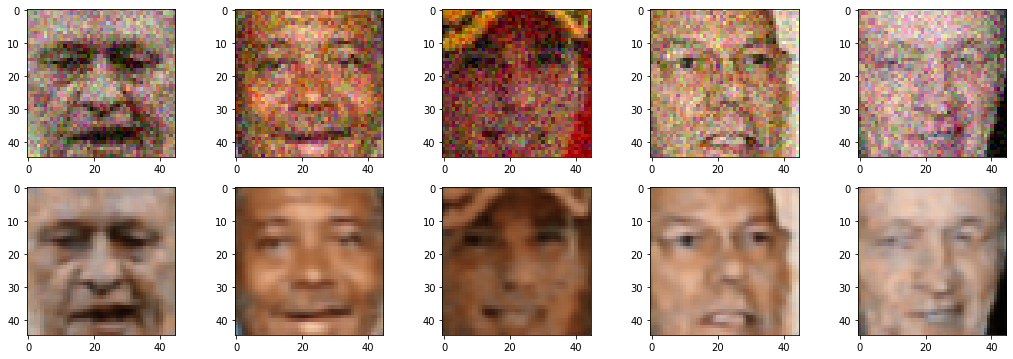

In [39]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_val), 5)

def predict_val(x, autoencoder):
  autoencoder.eval()
  with torch.no_grad():

    x = torch.from_numpy(np.rollaxis(x,3,1))
    x = x.to(torch.float32)  
    x = x.to(device)
    
    reconstruction, latent_code = autoencoder(x)
    x = reconstruction.cpu().detach().numpy()

    x = np.rollaxis(x,1,4)
    return x

x = predict_val(X_val_noisy[idx], autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_val_noisy[idx][i])

  plt.subplot(2, 5, 5+i+1)
  plt.imshow(x[i])
plt.show();

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [40]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>
import copy

# range for i coordinate: 0:45-w, w = 7
# range for j coordinate: 0:45-h, h = random(7, 14)

w = 7

# create random array of h
np.random.seed(seed=45)
h = np.random.randint(7, 14, len(X))

i_arr = np.random.randint(0, 45-w, len(X))
j_arr = np.random.randint(0, 45-14, len(X))

X_occluded = copy.deepcopy(X)

for i in range(0, len(X)):
  X_occluded[i][i_arr[i]:i_arr[i]+w, j_arr[i]:j_arr[i]+h[i]] = 1.0

In [41]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
from torch.utils.data import TensorDataset

X_train_noisy, X_val_noisy, X_train, X_val = train_test_split(X_occluded, X, test_size=0.3, random_state=42)

dataset_tr = TensorDataset(torch.Tensor(np.rollaxis(X_train_noisy, 3, 1)), torch.Tensor(np.rollaxis(X_train, 3, 1)))
dataset_val = TensorDataset(torch.Tensor(np.rollaxis(X_val_noisy, 3, 1)), torch.Tensor(np.rollaxis(X_val, 3, 1)))

loader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_val), 5)

def predict_val(x, autoencoder):
  autoencoder.eval()
  with torch.no_grad():

    x = torch.from_numpy(np.rollaxis(x,3,1))
    x = x.to(torch.float32)  
    x = x.to(device)
    
    reconstruction, latent_code = autoencoder(x)
    x = reconstruction.cpu().detach().numpy()

    x = np.rollaxis(x,1,4)
    return x

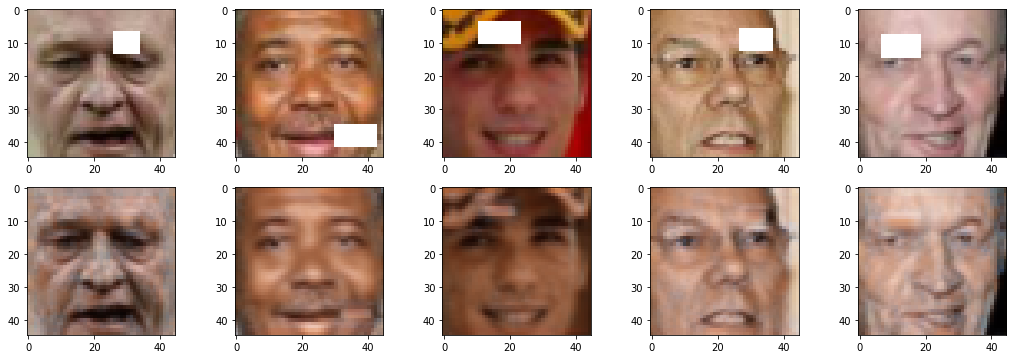

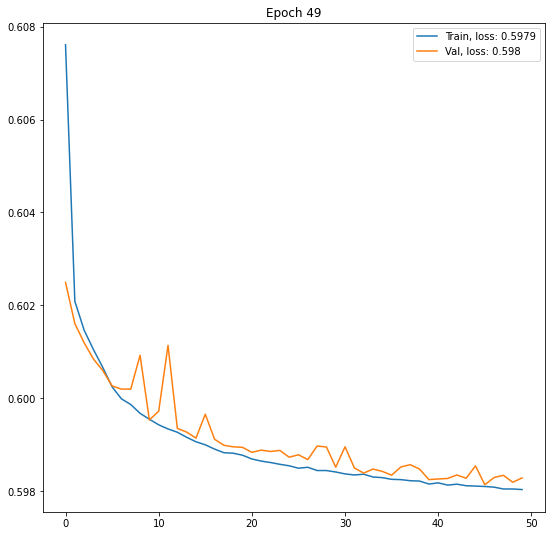

In [42]:
criterion = torch.nn.BCELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

from tqdm import notebook
from IPython.display import clear_output

epochs = 50

train_losses = []
val_losses = []

for epoch in range(epochs):
  print('* Epoch %d/%d' % (epoch, epochs))

  autoencoder.train()

  avg_loss=0
  
  for i, (X_batch_noisy, X_batch) in enumerate(notebook.tqdm(loader_tr)):
    X_batch_noisy = X_batch_noisy.to(device)
    X_batch = X_batch.to(device)

    # set parameter gradients to zero
    optimizer.zero_grad()

    # forward
    reconstruction, latent_code = autoencoder(X_batch_noisy)

    loss = criterion(reconstruction, X_batch.detach())
    avg_loss += loss / len(data_tr)

    # backward
    loss.backward() # backward-pass
    optimizer.step() # update weights

  print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
  train_losses.append(avg_loss)

  # evaluate model on validation set
  autoencoder.eval()  # testing mode
  val_loss = 0

  with torch.no_grad():
    for i, (X_batch_noisy, X_batch) in enumerate(notebook.tqdm(loader_val)):
      X_batch_noisy = X_batch_noisy.to(device)
      X_batch = X_batch.to(device)

      reconstruction, latent_code = autoencoder(X_batch_noisy)

      loss = criterion(reconstruction, X_batch.detach())
      val_loss += loss / len(data_val)

    print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    val_losses.append(val_loss)

    x = predict_val(X_val_noisy[idx], autoencoder)
    clear_output()
    plt.figure(figsize=(18,6))

  for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val_noisy[idx][i])

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(x[i])

  fig = plt.figure(figsize=(9, 9))
  plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
  plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')

  plt.title(f'Epoch {epoch}')
  plt.legend(loc='best')

    
  plt.show();




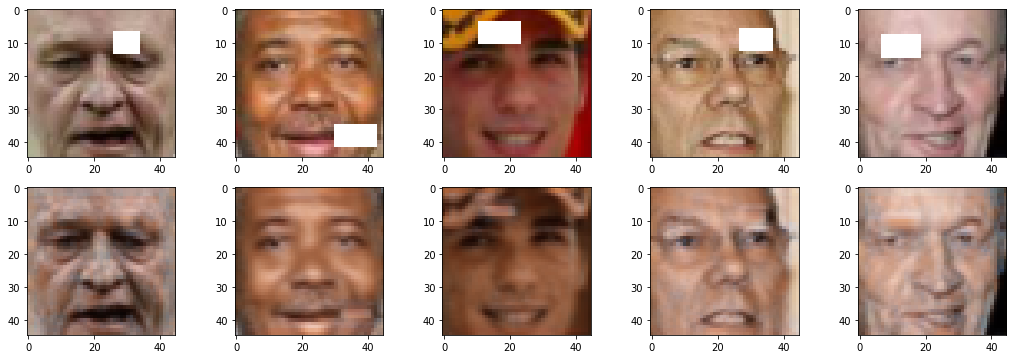

In [43]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>



x = predict_val(X_val_noisy[idx], autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_val_noisy[idx][i])

  plt.subplot(2, 5, 5+i+1)
  plt.imshow(x[i])
plt.show();

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [44]:
# codes = <поучите латентные представления картинок из трейна>

batch_size = 20

loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=batch_size, shuffle=False)

autoencoder.eval()
with torch.no_grad():
  for i, X_batch in enumerate(notebook.tqdm(loader)):

    if i == 0:
      X_batch = X_batch.to(torch.float32)  
      X_batch = X_batch.to(device)     
      latent_collection = autoencoder.encode(X_batch)
    else:
      X_batch = X_batch.to(torch.float32)  
      X_batch = X_batch.to(device)     
      latent = autoencoder.encode(X_batch)

      latent_collection = torch.cat((latent_collection, latent), 0)

codes = latent_collection.cpu().detach().numpy()
codes = codes.view().reshape((9200, 45*45))

In [45]:
# обучаем LSHForest
# from sklearn.neighbors import LSHForest
# lshf = LSHForest(n_estimators=50).fit(codes)

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(codes) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [46]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  # code = <получение латентного представления image>

  x = image
  x = torch.from_numpy(np.rollaxis(x,3,1))
  x = x.to(torch.float32)  
  x = x.to(device)

  latent = autoencoder.encode(x)
  code = latent.cpu().detach().numpy()
  code = code.view().reshape((1, 45*45))
    
  distances, idx = neigh.kneighbors(X=code, n_neighbors=n_neighbors, return_distance=True)
  idx = idx.flatten()
  distances = distances.flatten()

  return distances, X_train[idx]

In [47]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image[0])
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

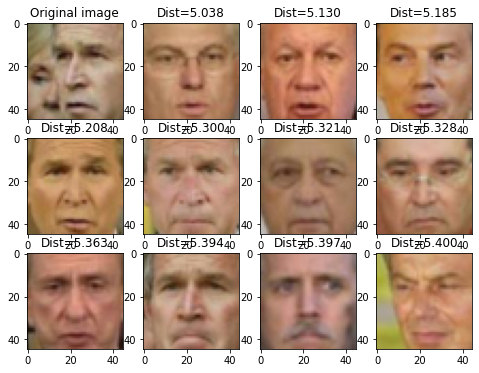

In [48]:
# <тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

i = 200
image = X_val[i:i+1]

show_similar(image)

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!